In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, explained_variance_score

In [2]:
outliers_df = pd.read_csv('outliers-data.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   prev_sold_date  7757 non-null   object 
 6   price           7757 non-null   float64
dtypes: float64(6), object(1)
memory usage: 424.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   price           7757 non-null   float64
 6   prev_sold_year  7757 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 424.3 KB


In [5]:
zip_lon_lat = pd.read_csv("county.csv")
zip_lon_lat.head()

,Unnamed: 0,zip_code,latitude,longitude,zip_code_str,county
0,0,7001,40.582316,-74.271506,7001,16
1,1,7002,40.662338,-74.110275,7002,2
2,2,7003,40.809128,-74.187155,7003,2
3,3,7004,40.882508,-74.304593,7004,19
4,4,7005,40.932771,-74.417304,7005,19


In [6]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how="inner", on="zip_code")
merged_df.tail()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,Unnamed: 0,latitude,longitude,zip_code_str,county
7749,5.0,4.0,0.91,8848.0,0.0,485000.0,2017,568,40.594266,-75.096659,8848,11
7750,4.0,3.0,2.17,8825.0,0.0,510000.0,2016,553,40.514169,-75.027112,8825,11
7751,3.0,2.0,0.12,7012.0,0.0,499000.0,2021,10,40.848398,-74.160266,7012,2
7752,3.0,3.0,0.13,7012.0,0.0,530000.0,2022,10,40.848398,-74.160266,7012,2
7753,4.0,3.0,0.11,7640.0,0.0,720000.0,2016,171,40.991681,-73.980202,7640,15


In [7]:
features = ["latitude","longitude","bed","bath","acre_lot","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

In [8]:
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [9]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

In [10]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

In [11]:
ridge = Ridge(random_state=42)
ridge_sfs = SequentialFeatureSelector(estimator=ridge, n_features_to_select=num_features_to_select)
ridge_sfm = SelectFromModel(estimator=ridge, threshold=1000)
ridge_rfe = RFE(estimator=ridge, n_features_to_select=num_features_to_select)

In [12]:
ridge_gscv = GridSearchCV(Ridge(random_state=42), {'alpha': [1e-11, 1e-10, 1e-9]}, scoring='neg_mean_squared_error')
ridge_gscv_model = ridge_gscv.fit(X, y)
print(f"Best parameters found: {ridge_gscv.best_params_}")

Best parameters found: {'alpha': 1e-10}


In [13]:
ridge = Ridge(**ridge_gscv.best_params_)
ridge_bp_gscv = GridSearchCV(ridge, param_grid={})
ridge_bp_model = ridge_bp_gscv.fit(X_train,y_train)
ridge_bp_predict = ridge_bp_model.predict(X_test)

print_more_stuff("Ridge Best Params", y_test, ridge_bp_predict, ridge_bp_gscv)

Ridge Best Params EVS = 0.413528582
Ridge Best Params MSE = 103,916,325,992.269440
Ridge Best Params MAE = 214,079.047688
Ridge Best Params R2 = 0.413192
Ridge Best Params Fit Time = 0.0026124954223632813


In [14]:
ridge_sfm_pipeline = Pipeline([
  ('feature_selection', ridge_sfm),
  ('regression', ridge)
])

ridge_sfm_fs = ridge_sfm_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
ridge_sfm_selected_features = ridge_sfm_fs.get_support()

print('The selected features are:', list(X.columns[ridge_sfm_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'acre_lot', 'prev_sold_year']


In [15]:
X_sfm = merged_df[list(X.columns[ridge_sfm_selected_features])]
y_sfm = merged_df["price"]
X_sfm_train, X_sfm_test, y_sfm_train, y_sfm_test = train_test_split(X_sfm, y_sfm, test_size=0.3, random_state=random_state_value)

In [16]:
ridge_sfm_gscv = GridSearchCV(Ridge(), param_grid={})
ridge_sfm_model = ridge_sfm_gscv.fit(X_sfm_train,y_sfm_train)
ridge_sfm_predict = ridge_sfm_model.predict(X_sfm_test)

print_more_stuff("Select From Model",y_sfm_test,ridge_sfm_predict,ridge_sfm_gscv)

Select From Model EVS = 0.412571191
Select From Model MSE = 104,097,563,698.364639
Select From Model MAE = 214,296.833643
Select From Model R2 = 0.412169
Select From Model Fit Time = 0.00341181755065918


In [17]:
ridge_sfs_pipeline = Pipeline([
  ('feature_selection', ridge_sfs),
  ('regression', ridge)
])

ridge_sfs_fs = ridge_sfs_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
ridge_sfs_selected_features = ridge_sfs_fs.get_support()

print('The selected features are:', list(X.columns[ridge_sfs_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size', 'prev_sold_year']


In [18]:
X_sfs = merged_df[list(X.columns[ridge_sfs_selected_features])]
y_sfs = merged_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [19]:
ridge_sfs_gscv = GridSearchCV(Ridge(), param_grid={})
ridge_sfs_model = ridge_sfs_gscv.fit(X_sfs_train,y_sfs_train)
ridge_sfs_predict = ridge_sfs_model.predict(X_sfs_test)

print_more_stuff("Sequential Feature Selector",y_sfs_test,ridge_sfs_predict,ridge_sfs_gscv)

Sequential Feature Selector EVS = 0.411540766
Sequential Feature Selector MSE = 104,271,874,353.513794
Sequential Feature Selector MAE = 214,375.303667
Sequential Feature Selector R2 = 0.411185
Sequential Feature Selector Fit Time = 0.0034198760986328125


In [20]:
ridge_rfe_pipeline = Pipeline([
  ('feature_selection', ridge_rfe),
  ('regression', ridge)
])
ridge_rfe_fs = ridge_rfe_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
ridge_rfe_selected_features = ridge_rfe_fs.get_support()

print('The selected features are:', list(X.columns[ridge_rfe_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'acre_lot', 'prev_sold_year']


In [21]:
X_rfe = merged_df[list(X.columns[ridge_rfe_selected_features])]
y_rfe = merged_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [23]:
ridge_rfe_gscv = GridSearchCV(Ridge(), param_grid={})
ridge_rfe_model = ridge_rfe_gscv.fit(X_rfe_train,y_rfe_train)
ridge_rfe_predict = ridge_rfe_model.predict(X_rfe_test)

print_more_stuff("Recursive Feature Elimination",y_rfe_test,ridge_rfe_predict, ridge_rfe_gscv)

Recursive Feature Elimination EVS = 0.412571191
Recursive Feature Elimination MSE = 104,097,563,698.364639
Recursive Feature Elimination MAE = 214,296.833643
Recursive Feature Elimination R2 = 0.412169
Recursive Feature Elimination Fit Time = 0.005198907852172851


In [24]:
ridge_bp_predict_df = pd.DataFrame(ridge_bp_predict).reset_index()
ridge_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_sfm_predict_df = pd.DataFrame(ridge_sfm_predict).reset_index()
ridge_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_sfs_predict_df = pd.DataFrame(ridge_sfs_predict).reset_index()
ridge_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_rfe_predict_df = pd.DataFrame(ridge_rfe_predict).reset_index()
ridge_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

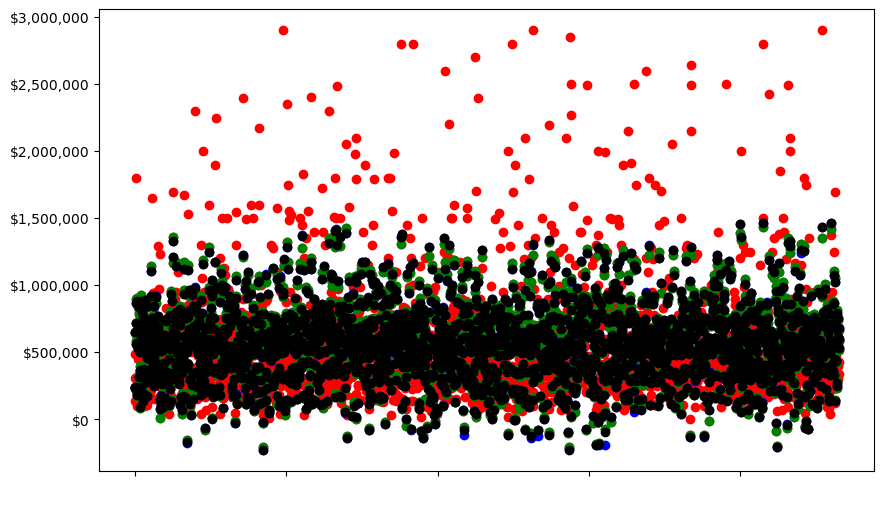

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(ridge_sfm_predict_df.index,ridge_sfm_predict_df["prediction"], color="brown")
plt.scatter(ridge_sfs_predict_df.index,ridge_sfs_predict_df["prediction"], color="blue")
plt.scatter(ridge_rfe_predict_df.index,ridge_rfe_predict_df["prediction"], color="green")
plt.scatter(ridge_bp_predict_df.index,ridge_bp_predict_df["prediction"], color="black")
plt.show()

In [26]:
ridge_bp_predict_df.sort_values(by='prediction', inplace=True)
ridge_bp_predict_df.reset_index(inplace=True)

ridge_sfm_predict_df.sort_values(by='prediction', inplace=True)
ridge_sfm_predict_df.reset_index(inplace=True)

ridge_sfs_predict_df.sort_values(by='prediction', inplace=True)
ridge_sfs_predict_df.reset_index(inplace=True)

ridge_rfe_predict_df.sort_values(by='prediction', inplace=True)
ridge_rfe_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

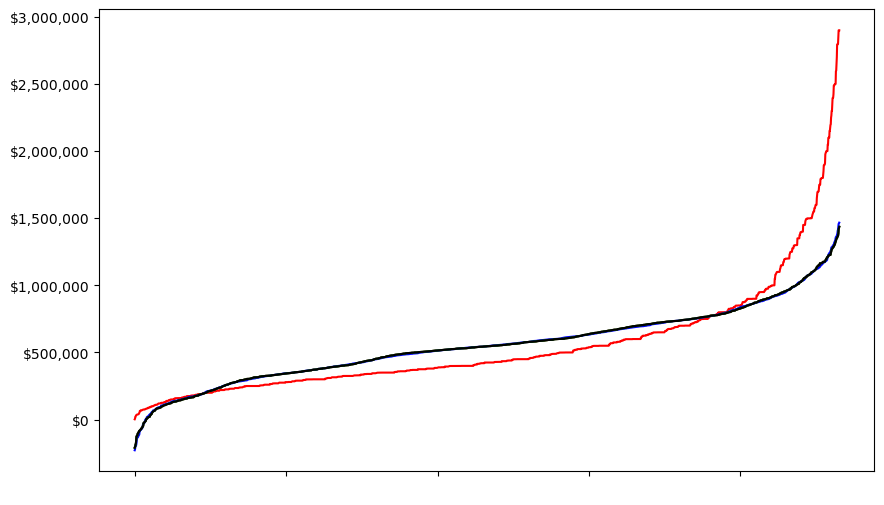

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')


plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(ridge_sfm_predict_df.index,ridge_sfm_predict_df["prediction"], color="brown")
plt.plot(ridge_sfs_predict_df.index,ridge_sfs_predict_df["prediction"], color="blue")
plt.plot(ridge_rfe_predict_df.index,ridge_rfe_predict_df["prediction"], color="green")
plt.plot(ridge_sfm_predict_df.index,ridge_sfm_predict_df["prediction"], color="black")
plt.show()

In [30]:
results_dict

{'model': ['Ridge Best Params',
  'Select From Model',
  'Sequential Feature Selector',
  'Recursive Feature Elimination'],
 'explained variance score': ['0.413528582',
  '0.412571191',
  '0.411540766',
  '0.412571191'],
 'mae score': ['214,079.047688',
  '214,296.833643',
  '214,375.303667',
  '214,296.833643'],
 'mse score': ['103,916,325,992.269440',
  '104,097,563,698.364639',
  '104,271,874,353.513794',
  '104,097,563,698.364639'],
 'r2 score': ['0.413192', '0.412169', '0.411185', '0.412169'],
 'mean fit time': [0.0026124954223632813,
  0.00341181755065918,
  0.0034198760986328125,
  0.005198907852172851]}

In [31]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Ridge Best Params,0.413528582,"214,079.047688","103,916,325,992.269440",0.413192,0.002612
Select From Model,0.412571191,"214,296.833643","104,097,563,698.364639",0.412169,0.003412
Sequential Feature Selector,0.411540766,"214,375.303667","104,271,874,353.513794",0.411185,0.003420
Recursive Feature Elimination,0.412571191,"214,296.833643","104,097,563,698.364639",0.412169,0.005199
